In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('fivethirtyeight')
import time
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import keras
import keras.backend as k
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Activation, Dropout, Bidirectional, Input, MultiHeadAttention, LayerNormalization, BatchNormalization, Flatten
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import callbacks
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpMode"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = (y_true.index)+1

    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

<ipython-input-3-e13a5a1ee8c5>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
<ipython-input-3-e13a5a1ee8c5>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
<ipython-input-3-e13a5a1ee8c5>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])


((20631, 20), (13096, 19), (100, 2))

In [5]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
df_train.head(5)

,UnitNumber,Cycle,OpMode1,OpMode2,OpMode3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL
0,1,1,-0.080460,-0.666667,-1.0,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.600784,-0.272028,-0.333333,0.426357,0.449323,191
1,1,2,0.218391,-0.500000,-1.0,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.674373,-0.177376,-0.333333,0.333333,0.462027,190
2,1,3,-0.494253,0.500000,-1.0,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.656414,-0.285110,-0.666667,0.255814,0.242751,189
3,1,4,0.080460,0.000000,-1.0,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.650222,-0.666795,-0.333333,0.147287,0.324772,188
4,1,5,-0.218391,-0.333333,-1.0,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.650532,-0.195845,-0.166667,0.178295,0.409003,187


In [7]:
df_test.head(5)

,UnitNumber,Cycle,OpMode1,OpMode2,OpMode3,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,-1.0,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.735680,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-1.0,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.590463,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-1.0,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.688719,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-1.0,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.659820,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-1.0,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.694499,-0.398230,-0.666667,0.317829,0.432753


In [8]:
y_true.head()

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [9]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [10]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [11]:
def gen_test(id_df, seq_length, seq_cols):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)

    id_df = pd.concat([df_mask, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements

    lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

In [12]:
sequence_length = 30

In [13]:
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17731, 30, 17)


In [14]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17731,)

In [15]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 30, 17)


In [16]:
#true target of test
y_test = y_true.RUL.values
y_test.shape

(100,)

In [17]:
rul_max = 125
corrected_y_train = np.where(y_train > rul_max, rul_max, y_train)
corrected_y_test = np.where(y_test > rul_max, rul_max, y_test)

In [18]:
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, corrected_y_train, test_size=0.2, random_state=42
)

In [ ]:
nb_features = x_train.shape[2]
nb_out = 1

In [21]:
def objective(trial):

    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-4, 1e-2, log=True)
    num_heads = trial.suggest_int('num_heads', 2, 8)

    inputs = Input(shape=(30, 17))

    x = Bidirectional(GRU(units=units1, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(inputs)
    x = LayerNormalization(epsilon=1e-5)(x)

    x = Bidirectional(GRU(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda)))(x)
    x = LayerNormalization(epsilon=1e-5)(x)

    # Temporal Self-Attention Layer with Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=17)(x, x)
    attention_output = LayerNormalization(epsilon=1e-5)(attention_output)

    x = Flatten()(attention_output)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(units=1, activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
    history = model.fit(x_train_split, y_train_split, epochs=32, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                                                   patience=15, verbose=1, mode='auto',
                                                                   restore_best_weights=True), reduce_lr])

    val_rmse = history.history['val_root_mean_squared_error'][-1]

    return val_rmse


In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)

print('Best trial:', study.best_trial.params)

[I 2024-12-20 05:22:09,166] A new study created in memory with name: no-name-b94bbae9-6330-4669-ba37-4a98c4c659e5


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 1034.2563 - root_mean_squared_error: 30.4247 - val_loss: 211.4512 - val_root_mean_squared_error: 14.5302 - learning_rate: 0.0053
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 198.4660 - root_mean_squared_error: 14.0751 - val_loss: 187.0905 - val_root_mean_squared_error: 13.6655 - learning_rate: 0.0053
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 189.7352 - root_mean_squared_error: 13.7573 - val_loss: 312.0829 - val_root_mean_squared_error: 17.6551 - learning_rate: 0.0053
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 174.9844 - root_mean_squared_error: 13.2053 - val_loss: 155.1390 - val_root_mean_squared_error: 12.4382 - learning_rate: 0.0053
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 164.2811 - root_mean_squared_error: 12.7985 - val_loss: 215.2167 - val_root_mean_squared_error: 14.6529 - learning_rate: 0.0053
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step 

[I 2024-12-20 05:25:08,734] Trial 0 finished with value: 3.437044858932495 and parameters: {'units1': 76, 'units2': 72, 'dropout_rate': 0.33766732417435, 'learning_rate': 0.005260823653465045, 'l2_lambda': 0.0005525585422196622, 'num_heads': 7}. Best is trial 0 with value: 3.437044858932495.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 1404.9750 - root_mean_squared_error: 34.9560 - val_loss: 191.7560 - val_root_mean_squared_error: 13.8459 - learning_rate: 0.0023
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 207.0648 - root_mean_squared_error: 14.3781 - val_loss: 173.5110 - val_root_mean_squared_error: 13.1705 - learning_rate: 0.0023
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 178.3939 - root_mean_squared_error: 13.3512 - val_loss: 168.9265 - val_root_mean_squared_error: 12.9951 - learning_rate: 0.0023
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 159.3043 - root_mean_squared_error: 12.6174 - val_loss: 139.6069 - val_root_mean_squared_error: 11.8131 - learning_rate: 0.0023
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 130.3465 - root_mean_squared_error: 11.4118 - val_loss: 117.9533 - val_root_mean_squared_error: 10.8576 - learning_rate: 0.0023
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step

[I 2024-12-20 05:28:16,458] Trial 1 finished with value: 2.725555658340454 and parameters: {'units1': 53, 'units2': 40, 'dropout_rate': 0.32088429170766375, 'learning_rate': 0.0023276953782585203, 'l2_lambda': 0.00014271220926190508, 'num_heads': 6}. Best is trial 1 with value: 2.725555658340454.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 1618.0531 - root_mean_squared_error: 37.7886 - val_loss: 225.5948 - val_root_mean_squared_error: 15.0162 - learning_rate: 4.9111e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 196.2466 - root_mean_squared_error: 14.0036 - val_loss: 176.3297 - val_root_mean_squared_error: 13.2748 - learning_rate: 4.9111e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 170.1946 - root_mean_squared_error: 13.0406 - val_loss: 167.1316 - val_root_mean_squared_error: 12.9237 - learning_rate: 4.9111e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 166.5537 - root_mean_squared_error: 12.8903 - val_loss: 152.8969 - val_root_mean_squared_error: 12.3606 - learning_rate: 4.9111e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 153.5652 - root_mean_squared_error: 12.3856 - val_loss: 155.0719 - val_root_mean_squared_error: 12.4482 - learning_rate: 4.9111e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:31:21,314] Trial 2 finished with value: 3.042663812637329 and parameters: {'units1': 32, 'units2': 126, 'dropout_rate': 0.28755003144963254, 'learning_rate': 0.0004911064265324698, 'l2_lambda': 0.00038199506030329083, 'num_heads': 5}. Best is trial 1 with value: 2.725555658340454.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 2398.8035 - root_mean_squared_error: 46.7791 - val_loss: 196.9971 - val_root_mean_squared_error: 14.0305 - learning_rate: 6.4677e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 189.7399 - root_mean_squared_error: 13.7673 - val_loss: 179.1910 - val_root_mean_squared_error: 13.3809 - learning_rate: 6.4677e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 171.9071 - root_mean_squared_error: 13.1042 - val_loss: 165.1606 - val_root_mean_squared_error: 12.8458 - learning_rate: 6.4677e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 152.8556 - root_mean_squared_error: 12.3573 - val_loss: 136.4594 - val_root_mean_squared_error: 11.6752 - learning_rate: 6.4677e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 144.2317 - root_mean_squared_error: 12.0019 - val_loss: 138.0662 - val_root_mean_squared_error: 11.7437 - learning_rate: 6.4677e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:34:12,147] Trial 3 finished with value: 2.694361925125122 and parameters: {'units1': 93, 'units2': 45, 'dropout_rate': 0.11113799448222533, 'learning_rate': 0.0006467671370895509, 'l2_lambda': 0.00036717077273421277, 'num_heads': 5}. Best is trial 3 with value: 2.694361925125122.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 4617.3013 - root_mean_squared_error: 67.0960 - val_loss: 517.8513 - val_root_mean_squared_error: 22.7545 - learning_rate: 2.0877e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 371.8242 - root_mean_squared_error: 19.2006 - val_loss: 202.7286 - val_root_mean_squared_error: 14.2352 - learning_rate: 2.0877e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 185.7859 - root_mean_squared_error: 13.6245 - val_loss: 164.6423 - val_root_mean_squared_error: 12.8279 - learning_rate: 2.0877e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 168.8997 - root_mean_squared_error: 12.9917 - val_loss: 161.7457 - val_root_mean_squared_error: 12.7145 - learning_rate: 2.0877e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 161.4645 - root_mean_squared_error: 12.7030 - val_loss: 149.9161 - val_root_mean_squared_error: 12.2404 - learning_rate: 2.0877e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:37:13,360] Trial 4 finished with value: 4.618675708770752 and parameters: {'units1': 127, 'units2': 39, 'dropout_rate': 0.36469730950991597, 'learning_rate': 0.0002087656340083275, 'l2_lambda': 0.0002223275651653193, 'num_heads': 5}. Best is trial 3 with value: 2.694361925125122.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 1522.0887 - root_mean_squared_error: 36.5164 - val_loss: 230.8219 - val_root_mean_squared_error: 15.0970 - learning_rate: 0.0020
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 207.7074 - root_mean_squared_error: 14.3059 - val_loss: 183.3712 - val_root_mean_squared_error: 13.4348 - learning_rate: 0.0020
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 180.6832 - root_mean_squared_error: 13.3328 - val_loss: 174.6881 - val_root_mean_squared_error: 13.1053 - learning_rate: 0.0020
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 167.2745 - root_mean_squared_error: 12.8095 - val_loss: 151.5557 - val_root_mean_squared_error: 12.1869 - learning_rate: 0.0020
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 138.7685 - root_mean_squared_error: 11.6457 - val_loss: 137.7265 - val_root_mean_squared_error: 11.5974 - learning_rate: 0.0020
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step 

[I 2024-12-20 05:40:00,168] Trial 5 finished with value: 2.870974063873291 and parameters: {'units1': 80, 'units2': 39, 'dropout_rate': 0.1683089697803514, 'learning_rate': 0.001952072241444723, 'l2_lambda': 0.008501082461097665, 'num_heads': 7}. Best is trial 3 with value: 2.694361925125122.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1096.7677 - root_mean_squared_error: 31.4163 - val_loss: 208.0018 - val_root_mean_squared_error: 14.4019 - learning_rate: 0.0085
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 202.3910 - root_mean_squared_error: 14.2039 - val_loss: 178.1125 - val_root_mean_squared_error: 13.3225 - learning_rate: 0.0085
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 201.3044 - root_mean_squared_error: 14.1623 - val_loss: 191.5342 - val_root_mean_squared_error: 13.8143 - learning_rate: 0.0085
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 181.5829 - root_mean_squared_error: 13.4448 - val_loss: 172.3125 - val_root_mean_squared_error: 13.0969 - learning_rate: 0.0085
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 160.7328 - root_mean_squared_error: 12.6433 - val_loss: 152.7325 - val_root_mean_squared_error: 12.3216 - learning_rate: 0.0085
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step 

[I 2024-12-20 05:42:36,752] Trial 6 finished with value: 2.2765612602233887 and parameters: {'units1': 88, 'units2': 43, 'dropout_rate': 0.2561290260673649, 'learning_rate': 0.00852155580458587, 'l2_lambda': 0.000893159039779198, 'num_heads': 8}. Best is trial 6 with value: 2.2765612602233887.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1484.9923 - root_mean_squared_error: 35.8925 - val_loss: 201.0284 - val_root_mean_squared_error: 14.1768 - learning_rate: 9.0320e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 192.7932 - root_mean_squared_error: 13.8799 - val_loss: 184.9877 - val_root_mean_squared_error: 13.5993 - learning_rate: 9.0320e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 163.2225 - root_mean_squared_error: 12.7716 - val_loss: 165.0729 - val_root_mean_squared_error: 12.8462 - learning_rate: 9.0320e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 152.9107 - root_mean_squared_error: 12.3610 - val_loss: 163.4283 - val_root_mean_squared_error: 12.7820 - learning_rate: 9.0320e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 150.3209 - root_mean_squared_error: 12.2544 - val_loss: 144.2948 - val_root_mean_squared_error: 12.0101 - learning_rate: 9.0320e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:45:11,638] Trial 7 finished with value: 2.659771203994751 and parameters: {'units1': 46, 'units2': 87, 'dropout_rate': 0.3775724637135941, 'learning_rate': 0.0009032003602133087, 'l2_lambda': 0.0001324677004056475, 'num_heads': 3}. Best is trial 6 with value: 2.2765612602233887.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 4255.7798 - root_mean_squared_error: 64.4090 - val_loss: 498.2922 - val_root_mean_squared_error: 22.3216 - learning_rate: 1.3266e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 344.9076 - root_mean_squared_error: 18.5183 - val_loss: 193.1475 - val_root_mean_squared_error: 13.8963 - learning_rate: 1.3266e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 190.6443 - root_mean_squared_error: 13.8015 - val_loss: 171.5318 - val_root_mean_squared_error: 13.0955 - learning_rate: 1.3266e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 163.5141 - root_mean_squared_error: 12.7851 - val_loss: 164.7109 - val_root_mean_squared_error: 12.8324 - learning_rate: 1.3266e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 157.6900 - root_mean_squared_error: 12.5548 - val_loss: 159.1213 - val_root_mean_squared_error: 12.6127 - learning_rate: 1.3266e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:47:59,876] Trial 8 finished with value: 5.7853851318359375 and parameters: {'units1': 58, 'units2': 65, 'dropout_rate': 0.27370085349141654, 'learning_rate': 0.00013266216104390531, 'l2_lambda': 0.00011386216117295935, 'num_heads': 6}. Best is trial 6 with value: 2.2765612602233887.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 1290.0211 - root_mean_squared_error: 33.5610 - val_loss: 295.0527 - val_root_mean_squared_error: 17.1721 - learning_rate: 9.2888e-04
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 218.7263 - root_mean_squared_error: 14.7716 - val_loss: 187.3049 - val_root_mean_squared_error: 13.6794 - learning_rate: 9.2888e-04
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 166.0541 - root_mean_squared_error: 12.8780 - val_loss: 158.7990 - val_root_mean_squared_error: 12.5943 - learning_rate: 9.2888e-04
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 151.5524 - root_mean_squared_error: 12.3022 - val_loss: 158.0961 - val_root_mean_squared_error: 12.5661 - learning_rate: 9.2888e-04
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 145.1853 - root_mean_squared_error: 12.0367 - val_loss: 149.0282 - val_root_mean_squared_error: 12.1996 - learning_rate: 9.2888e-04
Epoch 6/32
222/222 ━━━━━━━━━━━━━━

[I 2024-12-20 05:51:05,252] Trial 9 finished with value: 2.6365201473236084 and parameters: {'units1': 39, 'units2': 97, 'dropout_rate': 0.3487721167009844, 'learning_rate': 0.0009288761364274201, 'l2_lambda': 0.0005491562694361991, 'num_heads': 6}. Best is trial 6 with value: 2.2765612602233887.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 1491.6968 - root_mean_squared_error: 37.9085 - val_loss: 245.3250 - val_root_mean_squared_error: 15.5726 - learning_rate: 0.0085
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 229.3591 - root_mean_squared_error: 15.0496 - val_loss: 196.6599 - val_root_mean_squared_error: 13.9238 - learning_rate: 0.0085
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 212.7514 - root_mean_squared_error: 14.4804 - val_loss: 195.8185 - val_root_mean_squared_error: 13.8884 - learning_rate: 0.0085
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 188.5620 - root_mean_squared_error: 13.6231 - val_loss: 163.9715 - val_root_mean_squared_error: 12.6866 - learning_rate: 0.0085
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 179.9439 - root_mean_squared_error: 13.2973 - val_loss: 159.7471 - val_root_mean_squared_error: 12.5115 - learning_rate: 0.0085
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step 

[I 2024-12-20 05:54:11,887] Trial 10 finished with value: 5.617729663848877 and parameters: {'units1': 110, 'units2': 59, 'dropout_rate': 0.1943590598849621, 'learning_rate': 0.008471428357846764, 'l2_lambda': 0.0022671386961486484, 'num_heads': 8}. Best is trial 6 with value: 2.2765612602233887.


Epoch 1/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 1013.6433 - root_mean_squared_error: 29.8507 - val_loss: 232.2088 - val_root_mean_squared_error: 15.2124 - learning_rate: 0.0024
Epoch 2/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 225.2554 - root_mean_squared_error: 14.9760 - val_loss: 210.6883 - val_root_mean_squared_error: 14.4864 - learning_rate: 0.0024
Epoch 3/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 189.2910 - root_mean_squared_error: 13.7216 - val_loss: 202.6572 - val_root_mean_squared_error: 14.2051 - learning_rate: 0.0024
Epoch 4/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 158.5022 - root_mean_squared_error: 12.5536 - val_loss: 153.5419 - val_root_mean_squared_error: 12.3537 - learning_rate: 0.0024
Epoch 5/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 160.9022 - root_mean_squared_error: 12.6393 - val_loss: 182.6330 - val_root_mean_squared_error: 13.4765 - learning_rate: 0.0024
Epoch 6/32
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step 

[I 2024-12-20 05:57:29,432] Trial 11 finished with value: 2.2805161476135254 and parameters: {'units1': 96, 'units2': 95, 'dropout_rate': 0.22898567123136843, 'learning_rate': 0.002432020414990972, 'l2_lambda': 0.0013077920625040398, 'num_heads': 8}. Best is trial 6 with value: 2.2765612602233887.


Best trial: {'units1': 88, 'units2': 43, 'dropout_rate': 0.2561290260673649, 'learning_rate': 0.00852155580458587, 'l2_lambda': 0.000893159039779198, 'num_heads': 8}


In [23]:
best_params = study.best_trial.params
print(best_params)

inputs = Input(shape=(30, 17))

x = Bidirectional(GRU(units=best_params['units1'], return_sequences=True, kernel_regularizer=l2(best_params['l2_lambda'])))(inputs)
x = LayerNormalization(epsilon=1e-5)(x)

x = Bidirectional(GRU(units=best_params['units2'], return_sequences=True, kernel_regularizer=l2(best_params['l2_lambda'])))(x)
x = LayerNormalization(epsilon=1e-5)(x)

    # Temporal Self-Attention Layer with Multi-Head Attention
attention_output = MultiHeadAttention(num_heads=best_params['num_heads'], key_dim=17)(x, x)
attention_output = LayerNormalization(epsilon=1e-5)(attention_output)

x = Flatten()(attention_output)
x = Dropout(best_params['dropout_rate'])(x)

outputs = Dense(units=1, activation='relu', kernel_regularizer=l2(best_params['l2_lambda']))(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

{'units1': 88, 'units2': 43, 'dropout_rate': 0.2561290260673649, 'learning_rate': 0.00852155580458587, 'l2_lambda': 0.000893159039779198, 'num_heads': 8}


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 30, 17)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_26          │ (None, 30, 176)        │         56,496 │ input_layer_13[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_39    │ (None, 30, 176)        │            352 │ bidirectional_26[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_27          │ (None, 30, 86)         │         57,018 │ layer_normalization_3… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_40    │ (None, 30, 86)         │            172 │ bidirectional_27[0][0] │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_13   │ (None, 30, 86)         │         47,278 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_41    │ (None, 30, 86)         │            172 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 2580)           │              0 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 2580)           │              0 │ flatten_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1)              │          2,581 │ dropout_27[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 164,069 (640.89 KB)

 Trainable params: 164,069 (640.89 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
%%time
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

history = model.fit(x_train_split, y_train_split, epochs=64, batch_size=64,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stop, reduce_lr])

Epoch 1/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1104.6486 - root_mean_squared_error: 31.5622 - val_loss: 196.1172 - val_root_mean_squared_error: 13.9828 - learning_rate: 0.0085
Epoch 2/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 224.9577 - root_mean_squared_error: 14.9702 - val_loss: 190.3693 - val_root_mean_squared_error: 13.7745 - learning_rate: 0.0085
Epoch 3/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 192.7560 - root_mean_squared_error: 13.8596 - val_loss: 179.2384 - val_root_mean_squared_error: 13.3624 - learning_rate: 0.0085
Epoch 4/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 189.0115 - root_mean_squared_error: 13.7203 - val_loss: 164.2571 - val_root_mean_squared_error: 12.7856 - learning_rate: 0.0085
Epoch 5/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 168.7418 - root_mean_squared_error: 12.9567 - val_loss: 152.9814 - val_root_mean_squared_error: 12.3310 - learning_rate: 0.0085
Epoch 6/64
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step 

In [25]:
result_train = model.evaluate(x_train, corrected_y_train, verbose=1, batch_size=200)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12.0065 - root_mean_squared_error: 2.7009


In [26]:
result_test = model.evaluate(x_test, corrected_y_test, verbose=1, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 307.0796 - root_mean_squared_error: 17.3889


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


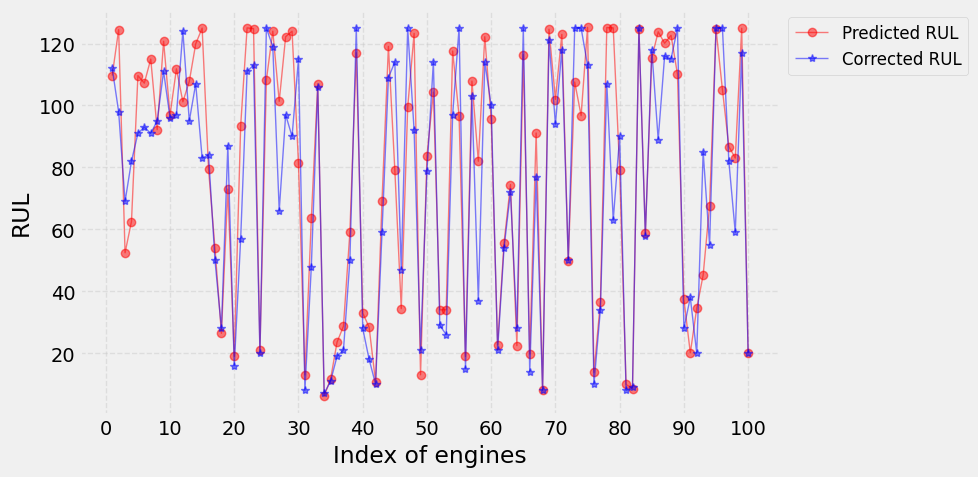

In [27]:
y_test_pred = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_test_pred) + 1), y_test_pred, 'ro-', label='Predicted RUL', linewidth=1, alpha=0.5)
plt.plot(range(1, len(corrected_y_test) + 1), corrected_y_test, 'b*-', label='Corrected RUL', linewidth=1, alpha=0.5)
plt.ylabel("RUL")
plt.xlabel("Index of engines")
plt.xticks(ticks=np.arange(0, 101, 10))
plt.grid(True, which='both', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.tight_layout()
plt.show()